In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.manifold import TSNE

# A convolutional neural network

In [71]:
class CNN_nn(nn.Module):
    def __init__(self,input_size, kernel_number, sequence_length, kernel_size, stride = 1, average_size = 1, output_size = 1):
        super(CNN_nn, self).__init__()
        #Attributes
        self.input_size = input_size #input size
        self.output_size = output_size #output size
        self.kernel_number = kernel_number #number of kernels
        self.kernel_size = kernel_size
        self.stride = stride
        self.average_size = average_size
        self.sequence_length = sequence_length-self.average_size+1 #length of the 1d input sequence
        self.scaler = StandardScaler()

        self.cnn1 = nn.Conv1d(self.input_size,4*self.kernel_number,self.kernel_size,self.stride) #Conv 1d
        self.cnn2 = nn.Conv1d(4*self.kernel_number,2*self.kernel_number,self.kernel_size,self.stride) #Conv 1d
        self.cnn3 = nn.Conv1d(2*self.kernel_number,self.kernel_number,self.kernel_size,self.stride) #Conv 1d
        self.max_pool = nn.MaxPool1d(2) #Max pooling

        example = self.cnn1(torch.randn(1,self.input_size,self.sequence_length)) # one batch to get the output length dimension
        example = self.max_pool(example)
        example = self.cnn2(example)
        example = self.max_pool(example)
        example = self.cnn3(example)
        example = self.max_pool(example)
        self.Lout = example.size(2) #Length of the output sequence

        self.fc = nn.Linear(self.kernel_number*self.Lout, self.output_size) #fully connected linear

        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def smoothening(self,X):
        rows = X.shape[0]
        columns = X.shape[1]
        res = np.zeros((rows,columns-self.average_size+1))
        for j in range(rows):
            for i in range(columns-self.average_size+1):
                res[j,i] = sum(X[j,i:i+self.average_size])/self.average_size
        return res

    def process_features(self, X):
        #Standardisation
        X_torch = self.scaler.transform(X)

        #Smoothening with moving average
        X_torch = self.smoothening(X_torch)
        
        #Reshaping
        X_torch = Variable(torch.Tensor(X_torch))
        X_torch = X_torch.reshape(-1,1,self.sequence_length)
        return X_torch

    def process_target(self, y):
        y_torch = []
        for i in range(len(y)):
            y_torch.append(y[i]-1)
        y_torch = Variable(torch.Tensor(y_torch))
        return y_torch

    def forward(self,X, cut = False):
        #First Layer
        out = self.cnn1(X)
        out = self.max_pool(out)
        out = self.relu(out)

        #Second Layer
        out = self.cnn2(out)
        out = self.max_pool(out)
        out = self.relu(out)

        #Third Layer
        out = self.cnn3(out)
        out = self.max_pool(out)

        #Flatten the last two dimensopn
        out = out.flatten(1,2)
        
        if cut:
            return out
        # Propagate input through fully connected linear neuron
        out = self.fc(out)

        # Activation with sigmoid
        out = self.sig(out)
        return out
    
    def forward_with_processing(self,X, cut = False):
        X_torch = self.process_features(X)
        return self.forward(X_torch,cut)
    
    def train(self, num_epochs, X_train, y_train, X_test, y_test):
        #total_p = sum([1 for x in y_train if x == 2])
        #total_n = sum([1 for x in y_train if x == 1])
        #self.weights = [total_p/len(y_train), total_n/len(y_train)]
        criterion = nn.BCELoss()
        self.scaler.fit(X_train)
        
        X_train = self.process_features(X_train)
        y_train = self.process_target(y_train)

        X_test = self.process_features(X_test)
        y_test = self.process_target(y_test)

        optimizer = torch.optim.Adam(self.parameters())

        train_hist = []
        test_hist = []

        for epoch in range(num_epochs+1):
            #Pass through the neural network
            train_outputs = self.forward(X_train) 
            test_outputs = self.forward(X_test) 

            #Reset gradients to zero  
            optimizer.zero_grad() 

            train_loss = criterion(train_outputs, y_train)
            test_loss = criterion(test_outputs,y_test)

            #Backprogagation step
            train_loss.backward()

            #Update weights and bias of the network
            optimizer.step()

            #Save train and test loss
            train_hist.append(train_loss.item())
            test_hist.append(test_loss.item())
        return train_hist, test_hist
    
    def print_confusion_matrix(self,X,y):
        y_predicted = self.forward_with_processing(X)
        y_ref = self.process_target(y)
        tp = 0.0
        tn = 0.0
        fp = 0.0
        fn = 0.0
        total_p = sum([1 for x in y_ref if x == 1])
        total_n = sum([1 for x in y_ref if x == 0])
        for i in range(len(y_predicted)):
            if abs(y_ref[i]-y_predicted[i]) < 0.5:
                if abs(y_predicted[i]-1) < 0.5:
                    tp += 1
                else:
                    tn += 1
            else:
                if abs(y_predicted[i]-1) < 0.5:
                    fn += 1
                else:
                    fp += 1
        df = pd.DataFrame([[tp,fn],[fp,tn]])
        print('Confusion matrix: ')
        print(df)

    def fourier_transform(self,X):
        FT = np.fft.fft(X,axis = 1)
        FT_norm = abs(FT)
        return FT_norm

    def plot_features(self, X, cut_low= 100, cut_high = 100):
        X_torch = X.reshape(1,-1)     
        FFT_norm = self.fourier_transform(X_torch)

        plt.clf()
        plot1 = plt.figure(1)
        plt.plot(X_torch[0], label = 'time domain')
        plt.grid()
        plt.show()

        plot2 = plt.figure(2)
        plt.plot(FFT_norm[0,cut_low:len(FFT_norm)-cut_high-1], label = 'frequency domain')
        plt.grid()
        plt.show()
    
    def embed_features(self,X,y):
        X_embedded = TSNE().fit_transform(self.forward_with_processing(X, cut = True).detach().cpu().numpy())
        plt.scatter(*X_embedded.T,c=y.flatten())
        plt.show()
        return X_embedded
    
    #def criterion(self, output, target):
        #epsilon = 1e-6
        #if self.weights is not None:
        #    loss = self.weights[1] * (target * torch.log(output + epsilon)) + self.weights[0] * ((1 - target) * torch.log(1 - output + epsilon))
        #else:
        #    loss = target * torch.log(output + epsilon) + (1 - target) * torch.log(1 - output + epsilon)
        #return torch.neg(torch.mean(loss))
        


# Data preprocessing

In [72]:
train_data = pd.read_csv('data/exoTrain.csv')
test_data = pd.read_csv('data/exoTest.csv')

In [73]:
sequence_length = 600
number_of_stars = 100
train_data = train_data.iloc[:number_of_stars,:sequence_length+1]
X_train = np.array(train_data.drop('LABEL',axis = 1))
y_train = np.array(train_data[['LABEL']]).reshape(-1,1)


In [74]:
test_data = test_data.iloc[:,:sequence_length+1]
X_test = np.array(test_data.drop('LABEL',axis = 1))
y_test = np.array(test_data[['LABEL']]).reshape(-1,1)

# Training

In [78]:
kernel_number = 5
kernel_size = 5
average_size = 1
model = CNN_nn(input_size=1, kernel_number = kernel_number, sequence_length=sequence_length, kernel_size=kernel_size, average_size=average_size)

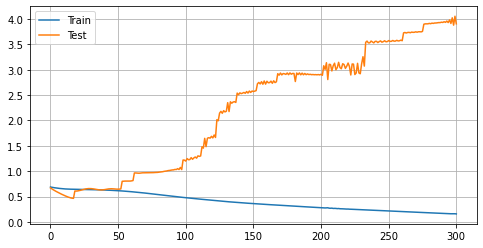

Confusion matrix: 
      0     1
0  33.0   1.0
1   4.0  62.0
Confusion matrix: 
     0      1
0  3.0   84.0
1  2.0  481.0


In [79]:
num_epochs = 300
train_hist, test_hist = model.train(num_epochs, X_train, y_train, X_test, y_test)
fig = plt.figure(figsize = (8,4))
plt.plot(train_hist, label = 'Train')
plt.plot(test_hist, label = 'Test')
plt.legend()
plt.grid()
plt.show()
model.print_confusion_matrix(X_train,y_train)
model.print_confusion_matrix(X_test,y_test)

# Visualization

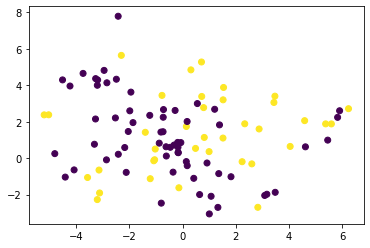

In [83]:
X_embedded = model.embed_features(X_train, y_train)

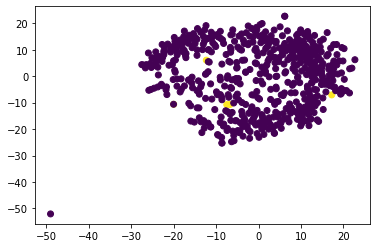

In [81]:
X_embedded = model.embed_features(X_test, y_test)

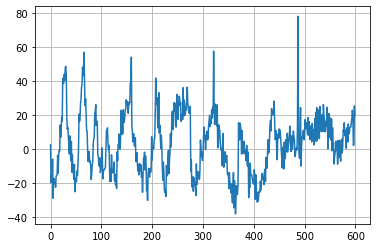

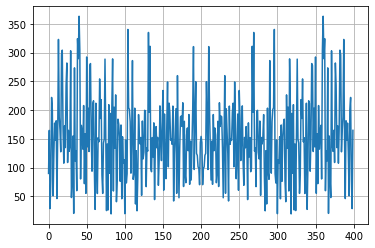

In [118]:
model.plot_features(X_train[53], cut_low=100, cut_high=100)